# Machine Learning

Ett grupparbete av Lilia Bezsmertna, Patrick Kepczynski, Tommie Ferrero och Erik Petersson

### I detta projekt kommer vår grupp att bygga en model för att prediktera bilpriser.

Steg 1:
Det vi har börjat med är att vi har importerat CSV-filen i VS Code och sedan läst in filen med pandas.read_csv och eftersom filen är semikolon sepererad så har vi använt sep=";" Vi kan se att det finns 10 000 rader i varje kolumn, 10 kolumner och inga nollvärden etc. (Vi får finslipa texterna, detta är bara liten start)

In [13]:
#Grundläggande datahantering och matematiska operationer
import numpy as np
import pandas as pd

#Visualisering
import matplotlib.pyplot as plt
import seaborn as sns  

#Dela upp data
from sklearn.model_selection import train_test_split, GridSearchCV

#Förbehandling av data
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

#Modeller
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

#Utvärdering
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df = pd.read_csv("car_price_dataset.csv", sep=";")

# 2. Datafördelning 

Vi delar upp datan i X och y samt i tränings- och testdata (20% test). 
Validering görs med hjälp av *cross-validation* i GridSearchCV, där träningsdatan automatiskt delas upp i tränings- och valideringsfolds. 
På så sätt använder vi både tränings-, validerings- och testdata utan att riskera data leakage (testdatan används endast allra sist).

In [14]:
# Delar upp i X och y
X = df.drop("Price", axis=1)
y = df["Price"]

# Delar upp i (hel)tränings- och 20% testset
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


# Skapa en EDA-dataframe 
EDA_train_df = X_train_full.copy()
EDA_train_df["Price"] = y_train_full

print(EDA_train_df.head()) #visar de första raderna i datan
print(EDA_train_df.shape)  #kollar storlek på rader och kolumner
print(EDA_train_df.info()) # kontrollerar kolumner och datatyper

           Brand     Model  Year  Engine_Size Fuel_Type    Transmission  \
9254  Volkswagen      Golf  2007          3.2    Hybrid  Semi-Automatic   
1561         BMW  5 Series  2010          4.8  Electric  Semi-Automatic   
1670     Hyundai    Sonata  2006          1.9    Hybrid  Semi-Automatic   
6087       Honda      CR-V  2019          1.7    Diesel  Semi-Automatic   
6669    Mercedes   E-Class  2005          3.6    Petrol       Automatic   

      Mileage  Doors  Owner_Count  Price  
9254    33948      5            4   9721  
1561   224853      2            1   9402  
1670    13435      3            5   8531  
6087   199846      2            3   7503  
6669      261      3            2  10694  
(8000, 10)
<class 'pandas.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         8000 non-null   str    
 1   Model         8000 non-null   str    
 2   Year     

# 3. EDA

### 3.1 Deskriptiv statistik

In [15]:
print(EDA_train_df.describe()) # Medelvärde, median, min/max, standardavvikelse
print()
print(EDA_train_df['Brand'].value_counts()) # Antal unika värden i kategoriska kolumner. Kan också visualiseras med tex ett stapeldiagram. 
print()
print(EDA_train_df['Model'].value_counts()) # Antal unika värden i kategoriska kolumner. Kan också visualiseras med tex ett stapeldiagram. 
print()
print(EDA_train_df['Fuel_Type'].value_counts()) # Antal unika värden i kategoriska kolumner. Kan också visualiseras med tex ett stapeldiagram. 
print()
print(EDA_train_df['Transmission'].value_counts()) # Antal unika värden i kategoriska kolumner. Kan också visualiseras med tex ett stapeldiagram. 
print()
print("Amount of brands:", EDA_train_df['Brand'].nunique()) # Antal unika bilar i datasetet
print("Amount of models:", EDA_train_df['Model'].nunique()) # Antal unika modeller i datasetet

              Year  Engine_Size        Mileage        Doors  Owner_Count  \
count  8000.000000  8000.000000    8000.000000  8000.000000  8000.000000   
mean   2011.520375     2.996887  149477.003250     3.503625     2.991875   
std       6.897792     1.153237   86613.284937     1.111482     1.420849   
min    2000.000000     1.000000      25.000000     2.000000     1.000000   
25%    2006.000000     2.000000   74192.250000     3.000000     2.000000   
50%    2012.000000     3.000000  150069.500000     4.000000     3.000000   
75%    2017.000000     4.000000  224292.750000     4.000000     4.000000   
max    2023.000000     5.000000  299947.000000     5.000000     5.000000   

              Price  
count   8000.000000  
mean    8828.745250  
std     3132.164285  
min     2000.000000  
25%     6604.750000  
50%     8829.000000  
75%    11071.000000  
max    18301.000000  

Brand
Audi          851
Volkswagen    828
Ford          826
Hyundai       818
Honda         807
Chevrolet     799
BM

### 3.2 Visualisering

1. Histogrammen visar att bilpriserna är ungefär symmetriskt fördelade med en svag högerskevhet. De flesta bilar ligger i ett genomsnittligt prisintervall, medan mycket höga priser förekommer mer sällan.

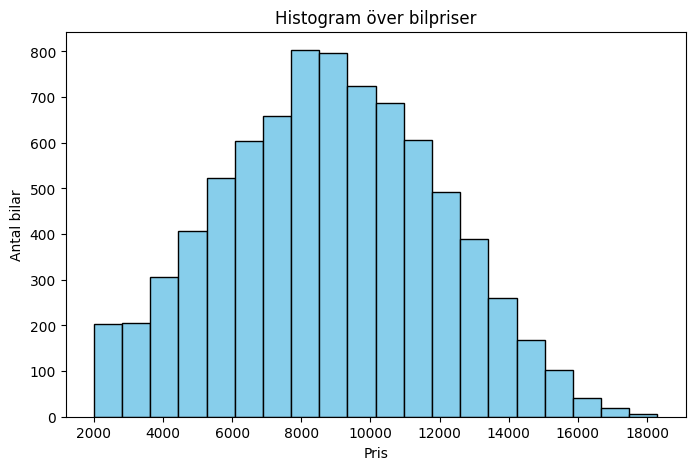

In [16]:
# Histogram över bilpriser

plt.figure(figsize=(8,5))
plt.hist(EDA_train_df['Price'], bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram över bilpriser")
plt.xlabel("Pris")
plt.ylabel("Antal bilar")
plt.show()

# Visar på form på fördelning: Symmetrisk (normalfördelad), skev åt höger, skev åt vänster

2. Boxploten visar att prisfördelningen är relativt likartad mellan olika bilmärken. Medianpriserna skiljer sig endast marginellt, medan vissa märken uppvisar högre spridning och enstaka outliers, vilket indikerar variation inom respektive märke snarare än stora skillnader mellan märkena.

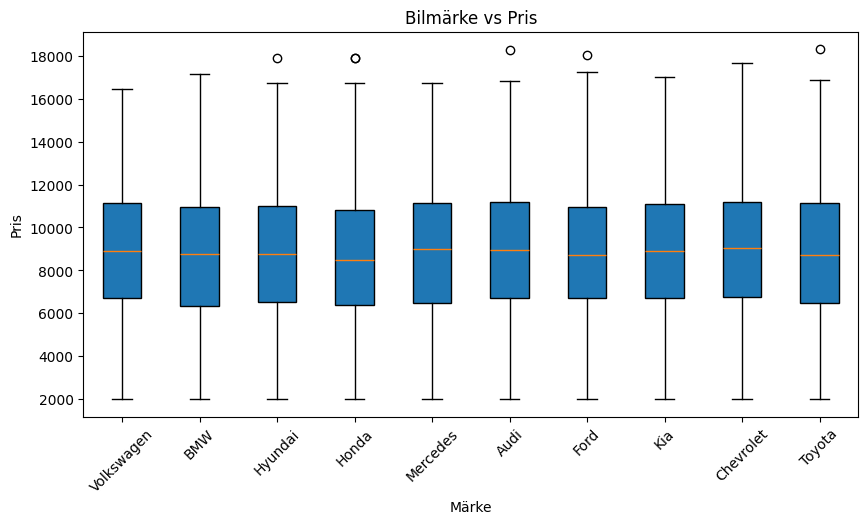

In [20]:
#Boxplot av pris per bilmärke

plt.figure(figsize=(10,5))
brands = EDA_train_df['Brand'].unique()
data_to_plot = [EDA_train_df[EDA_train_df['Brand']==brand]['Price'] for brand in brands]

plt.boxplot(data_to_plot, tick_labels=brands, patch_artist=True)
plt.title("Bilmärke vs Pris")
plt.xlabel("Märke")
plt.ylabel("Pris")
plt.xticks(rotation=45)
plt.show()
# Identifiera outliers som är relativa till gruppen, inte hela datan.

3. Boxploten visar att prisfördelningen för de 15 vanligaste bilmodellerna är relativt likartad, med jämförbara medianpriser och spridning. Skillnaderna i pris förekommer främst inom varje modell, medan skillnaderna mellan modellerna är mindre tydliga.

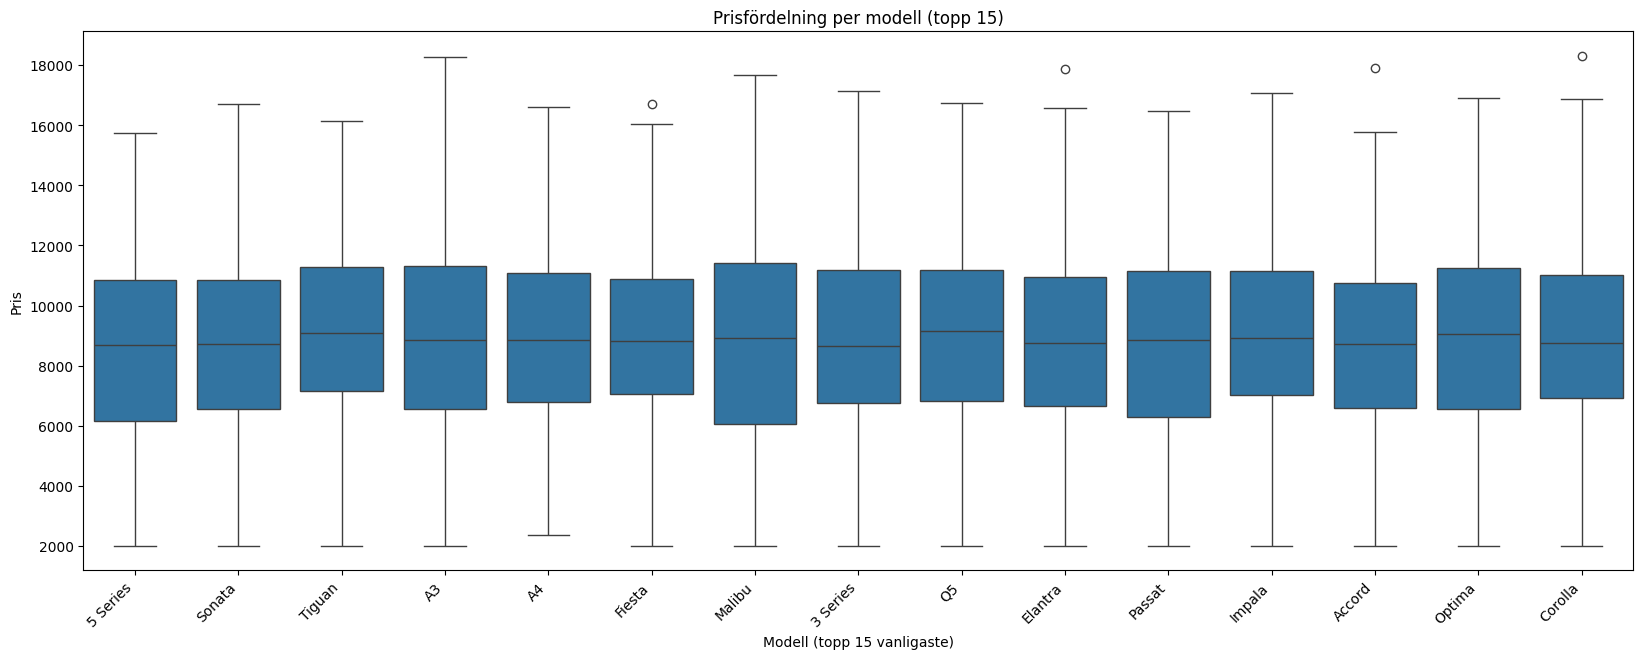

In [18]:
# Modell vs Pris (Model är kategorisk)
# För många unika modeller gör en scatter-plot svårtolkad, så vi visar boxplot för de vanligaste modellerna.

plt.figure(figsize=(20,7))

top_models = EDA_train_df['Model'].value_counts().head(15).index
sns.boxplot(data=EDA_train_df[EDA_train_df['Model'].isin(top_models)],
            x='Model', y='Price')
plt.xlabel("Modell (topp 15 vanligaste)")
plt.ylabel("Pris")
plt.xticks(rotation=45, ha='right')
plt.title("Prisfördelning per modell (topp 15)")
plt.show()

4. Boxploten visar att bilar med automatisk växellåda generellt har högre medianpris och större prisspridning jämfört med manuella och semi-automatiska bilar. Manuella växellådor tenderar att ha lägre prisnivåer, medan vissa överlappningar och enstaka outliers förekommer mellan grupperna.

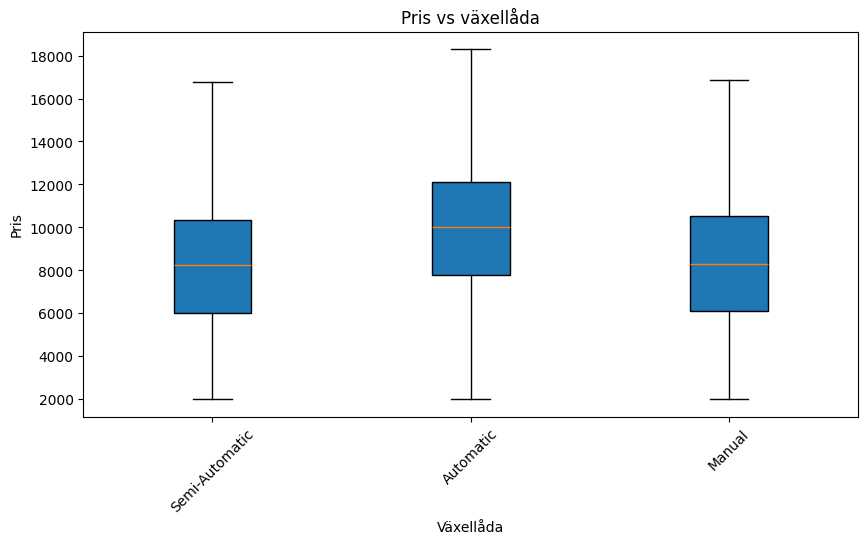

In [22]:
# Boxplot av pris per växellåda

plt.figure(figsize=(10,5))
transmission = EDA_train_df['Transmission'].unique()
data_to_plot = [EDA_train_df[EDA_train_df['Transmission']==t]['Price'] for t in transmission]

plt.boxplot(data_to_plot, tick_labels=transmission, patch_artist=True)
plt.title("Pris vs växellåda")
plt.xlabel("Växellåda")
plt.ylabel("Pris")
plt.xticks(rotation=45)
plt.show()
# Identifiera outliers som är relativa till gruppen, inte hela datan.

5. Korrelationsmatrisen visar sambanden mellan de numeriska variablerna i datasetet. Resultaten indikerar att bilpriset har en stark positiv korrelation med tillverkningsår (Year), vilket innebär att nyare bilar generellt har högre priser. Det finns även en måttlig positiv korrelation mellan motorstorlek (Engine Size) och pris. Samtidigt observeras en tydlig negativ korrelation mellan körsträcka (Mileage) och pris, vilket tyder på att bilar med högre körsträcka tenderar att ha lägre värde. Övriga variabler uppvisar svaga eller obetydliga samband med priset.


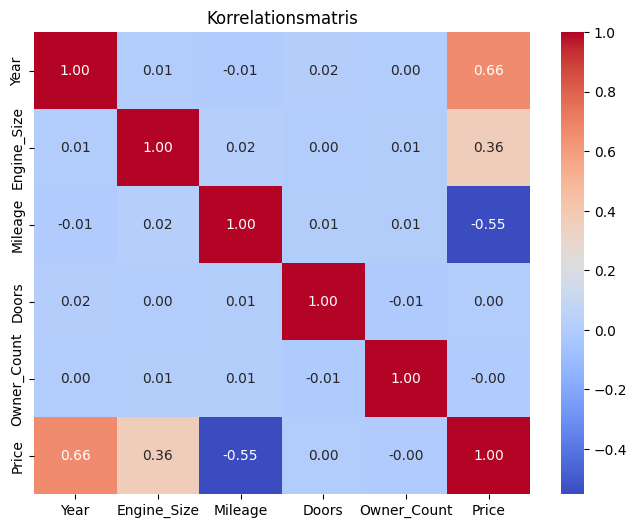

In [23]:
# Korrelationsmatris

plt.figure(figsize=(8,6))
sns.heatmap(EDA_train_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Korrelationsmatris")
plt.show()

#### Kort sammanfattning: Baserat på den explorativa dataanalysen valdes Year, Mileage och Engine Size som numeriska variabler, då dessa uppvisade tydliga samband med priset. De kategoriska variablerna Fuel_Type och Transmission inkluderades eftersom de har ett begränsat antal kategorier och förväntas påverka bilpriset. 

#### Owner_Count och Doors bör exkluderas på grund av låg korrelation med målvariabeln.

Innan modellen tränas förbehandlas datan för att kunna användas i maskininlärningsmodeller. Numeriska variabler hanteras genom att saknade värden ersätts med medianvärdet, medan kategoriska variabler omvandlas till numeriska värden med hjälp av One-Hot Encoding. Förbehandlingen anpassas endast på träningsdatan och appliceras därefter på validerings- och testdata för att undvika dataläckage.

Kategoriska variabler omvandlas till numeriska representationer med hjälp av One-Hot Encoding, där varje kategori kodas som en binär variabel. För att modellen ska kunna hantera kategorier som eventuellt endast förekommer i validerings- eller testdatan används inställningen handle_unknown="ignore".

Dessa förbehandlingssteg kombineras med hjälp av en ColumnTransformer, vilket möjliggör att olika transformationer appliceras på olika typer av variabler inom samma pipeline. Förbehandlingen anpassas (fit) endast på träningsdatan och appliceras därefter på validerings- och testdatan, vilket säkerställer att ingen information från framtida data läcker in i träningsprocessen. Slutligen resulterar förbehandlingen i en numerisk funktionsmatris som kan användas direkt av modellen.

# 4. Bearbeta data

I datan finns inga tomma värden.
Outliers väljer vi att ha med, eftersom de är förhållandevis nära resten av datasetet.
Vi omvandlar däremot kategoriska värden med OneHotEncoder.

Top 20 variabler (starkast samband med Price, efter OHE):


Year                           0.663176
Mileage                       -0.551387
Engine_Size                    0.362010
Fuel_Type_Electric             0.232763
Fuel_Type_Petrol              -0.147461
Transmission_Semi-Automatic   -0.140118
Transmission_Manual           -0.111950
Fuel_Type_Hybrid               0.048181
Model_Civic                   -0.029381
Brand_Honda                   -0.026062
Model_X5                      -0.020178
Brand_Chevrolet                0.020176
Model_Tiguan                   0.019784
Brand_BMW                     -0.018843
Model_Impala                   0.016253
Model_Equinox                  0.015100
Model_5 Series                -0.013449
Model_Focus                   -0.013334
Model_Q5                       0.012256
Model_RAV4                    -0.011282
Name: Price, dtype: float64

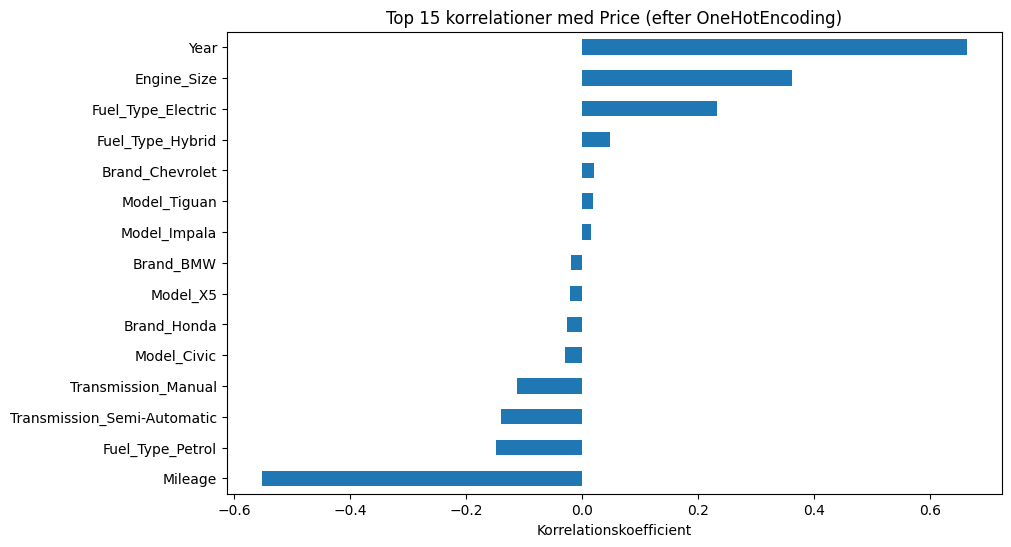

In [24]:
# För EDA: OneHotEncode kategoriska variabler för att kunna analysera samband med Price.
# OBS: Detta används bara för EDA-analys (separat från pipeline för modellträning).

num_cols = ['Year', 'Engine_Size', 'Mileage']
cat_cols = ['Fuel_Type', 'Transmission', 'Brand', 'Model']

# Version-säker OneHotEncoder (sparse_output -> nyare sklearn, sparse -> äldre)
try:
    ohe_eda = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe_eda = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

cat_encoded = ohe_eda.fit_transform(EDA_train_df[cat_cols])  # FIT ENDAS på TRAIN!
eda_numeric = EDA_train_df[num_cols].copy()

eda_ohe = pd.DataFrame(cat_encoded,
                       columns=ohe_eda.get_feature_names_out(cat_cols),
                       index=EDA_train_df.index)

eda_full = pd.concat([eda_numeric, eda_ohe, EDA_train_df['Price']], axis=1)

# Korrelationsanalys (efter OHE): vilka features har starkast samband med Price?
corr_with_price = eda_full.corr(numeric_only=True)['Price'].drop('Price')
corr_with_price_sorted = corr_with_price.reindex(corr_with_price.abs().sort_values(ascending=False).index)

print("Top 20 variabler (starkast samband med Price, efter OHE):")
display(corr_with_price_sorted.head(20))

# Visualisera topp 15
plt.figure(figsize=(10,6))
corr_with_price_sorted.head(15).sort_values().plot(kind='barh')
plt.xlabel("Korrelationskoefficient")
plt.title("Top 15 korrelationer med Price (efter OneHotEncoding)")
plt.show()


# 5. Modellering

Motivering av modellval:

Vi har valt att arbeta med tre modeller: LinearRegression, Ridge och RandomForest. 

LinearRegression fungerar som vår baseline-modell och ger oss en enkel referenspunkt genom att anta linjära samband mellan features och bilpris. 

Ridge bygger vidare på detta genom att lägga till L2-regularisering, vilket förhindrar överanpassning när vi har många features efter OneHotEncoding. Detta gör Ridge mer robust än vanlig linjär regression. 

RandomForest representerar en helt annan modellkategori baserad på beslutträd istället för linjära ekvationer. Som en ensemble-metod kan den fånga icke-linjära samband och komplexa interaktioner mellan variabler som de linjära modellerna missar. RandomForest är också robust mot outliers och behöver mindre förbehandling av data. Tillsammans ger dessa tre modeller oss en progression från enkel till avancerad modellering, samtidigt som de täcker både linjära och icke-linjära metoder. Alla tre modeller är etablerade inom maskininlärning och rekommenderas i kurslitteraturen för regressionsproblem.

Pipeline med OneHotEncoder för våra modeller

In [26]:
# Preprocessor (återanvänd!)
# Vi definierar en egen OneHotEncoder för pipeline (fit sker under träning/CV).
try:
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    [('cat', ohe, cat_cols)],      # cat_cols definierade ovan
    remainder='passthrough'        # Numeriska kolumner oförändrade
)

# 1. Pipeline för LINJÄR REGRESSION
lr_pipe = Pipeline([
    ('preproc', preprocessor),
    ('model', LinearRegression())
])

# 2. Pipeline för RIDGE (regularisering mot overfitting)
ridge_pipe = Pipeline([
    ('preproc', preprocessor),
    ('model', Ridge(alpha=1.0)) # alpha styr regularisering
])

# 3. Pipeline för RANDOM FOREST (non-linjär)
rf_pipe = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


Hyperparameter-tuning med GridSearchCV

In [27]:
# 1. LINJÄR (ingen tuning, men CV fr RMSE-baslinje)

lr_grid = GridSearchCV(lr_pipe, {}, cv=5, scoring='neg_root_mean_squared_error')
lr_grid.fit(X_train_full, y_train_full)
print("Linjär CV RMSE:", -lr_grid.best_score_)

# 2. RIDGE (tunar alpha mot overfitting)

ridge_grid = GridSearchCV(ridge_pipe, {'model__alpha': [0.01, 0.1, 1.0, 10.0]}, cv=5, scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train_full, y_train_full)
print("Ridge CV RMSE:", -ridge_grid.best_score_)
print("Bästa alpha:", ridge_grid.best_params_)

# 3. RANDOM FOREST (tunar träd & djup)

rf_param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 2, 5]
}
rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='neg_root_mean_squared_error')
rf_grid.fit(X_train_full, y_train_full)
print("RF CV RMSE:", -rf_grid.best_score_)
print("Bästa params:", rf_grid.best_params_)

Linjär CV RMSE: 89.06270785806586


c:\Users\bezsm\OneDrive\Dokument\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 1.295279047447416e-16.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bezsm\OneDrive\Dokument\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 1.310984873555587e-16.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bezsm\OneDrive\Dokument\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 1.3037243187622218e-16.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\bezsm\OneDrive\Dokument\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:228: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 1.3016550366845

Ridge CV RMSE: 89.06281128090498
Bästa alpha: {'model__alpha': 0.01}
RF CV RMSE: 564.7985348052329
Bästa params: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__n_estimators': 300}


Varningen uppstår eftersom OneHotEncoding skapar många korrelerade variabler, vilket kan leda till en numeriskt instabil (ill-conditioned) matris. Detta är vanligt vid linjära modeller med kategoriska variabler och påverkar inte modellens funktion, särskilt inte vid användning av Ridge-regression som hanterar multikollinearitet genom regularisering.

### Test och jämförelse av modellerna

In [28]:
models = {
    'Linjär': lr_grid.best_estimator_,
    'Ridge': ridge_grid.best_estimator_,
    'RF': rf_grid.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} | Test RMSE: {rmse:.2f} | MAE: {mae:.2f} | R2: {r2:.3f}")

Linjär | Test RMSE: 64.91 | MAE: 20.00 | R2: 1.000
Ridge | Test RMSE: 64.92 | MAE: 20.01 | R2: 1.000
RF | Test RMSE: 516.78 | MAE: 417.81 | R2: 0.971


## Slutsats

I denna studie har olika maskininlärningsmodeller jämförts för att prediktera bilpriser baserat på både numeriska och kategoriska variabler. Genom en noggrann explorativ dataanalys identifierades relevanta mönster och samband i träningsdatan, vilket låg till grund för val av modeller och databehandling.

Tre modeller utvärderades: linjär regression, Ridge-regression och Random Forest. Resultaten visar att de linjära modellerna, särskilt Ridge-regression, uppnådde bäst prestanda med lägst RMSE på både validerings- och testdatan. Detta indikerar att sambandet mellan de använda variablerna och bilpriset i huvudsak är linjärt. Ridge-regression valdes som slutlig modell eftersom den hanterar multikollinearitet genom regularisering och därmed ger en mer stabil och robust modell jämfört med vanlig linjär regression.

Random Forest presterade sämre i detta fall, vilket kan bero på begränsad datamängd samt att de underliggande relationerna i datan inte är tillräckligt komplexa för att dra nytta av en mer flexibel, icke-linjär modell.

Sammanfattningsvis visar resultaten att Ridge-regression är ett lämpligt val för denna uppgift, då modellen kombinerar god prediktionsförmåga med stabilitet och tolkbarhet.